In [1]:
import os
from pathlib import Path
from decimal import ROUND_HALF_UP, Decimal

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
# I/O Func
MODEL_NAME = "APPLE"
BASE_PATH = Path(f'/kaggle/working')

def adjusting_price(price, key: str):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[f"CumulativeAdjustmentFactor{key}"] * df[key]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def adjusting_volume(price, key = "Volume"):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[key] / df[f"CumulativeAdjustmentFactor{key}"]  
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def read_prices(dir_name: str, securities_code: int = None):
    """[Important: the dateset of 2020/10/1 is lost because of system failer in JPX, see: https://www.jpx.co.jp/corporate/news/news-releases/0060/20201019-01.html]
    
    """
    base_path = Path(f'../input/jpx-tokyo-stock-exchange-prediction/{dir_name}')
    df = pd.read_csv(base_path / 'stock_prices.csv')
    df = df[df['Open'].notna()]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def read_stock_list(securities_code: int = None, only_universe: bool = True):
    df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')
    if only_universe:
        df = df[df['Universe0']]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def merge_data(prices, stock_list):
    # stock_prices がベース
    base_df = prices.copy()
    
    # stock_listと結合
    _stock_list = stock_list.copy()
    _stock_list.rename(columns={'Close': 'Close_x'}, inplace=True)
    base_df = base_df.merge(_stock_list, on='SecuritiesCode', how="left")
    # format
    base_df.loc[: ,"Date"] = pd.to_datetime(base_df.loc[: ,"Date"], format="%Y-%m-%d")
    base_df.loc[: ,"EffectiveDate"] = pd.to_datetime(base_df.loc[: ,"EffectiveDate"], format="%Y%m%d")
    return base_df

def read_train_data_by_price(securities_code: int = None, with_supplemental: bool = True):
    """[The train base is price dataset, the other data are joined to prices DF by left join]
    
    """
    # origin
    df = merge_data(prices=read_prices(dir_name="train_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
    
    # supplyment
    if with_supplemental:
        supplemental_df = merge_data(prices=read_prices(dir_name="supplemental_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
        df = pd.concat([df, supplemental_df]).reset_index(drop=True)
        
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def collector(prices, options, financials, trades, secondary_prices, stock_list):
    # 読み込んだデータを統合して一つのファイルに纏める
    df = merge_data(prices, stock_list)
    # AdjustedClose項目の生成
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def write_df(df, filename):
    df.to_csv(f'{BASE_PATH}/{filename}_{MODEL_NAME}.csv',index = False)
    
import joblib
def write_model(model, name):
    # save model
    joblib.dump(model, f'{BASE_PATH}/{name}_{MODEL_NAME}.pkl')


# load model
def read_model(name):
    return joblib.load(f'{BASE_PATH}/{name}_{MODEL_NAME}.pkl')

In [3]:
stock_list = read_stock_list()
stock_list

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
19,1332,20211230,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,543.0,312430277.0,1.696496e+11,True
20,1333,20211230,Maruha Nichiro Corporation,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,2405.0,52656910.0,1.266399e+11,True
37,1375,20211230,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,20211230.0,1196.0,39910700.0,4.773320e+10,True
38,1376,20211230,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,1504.0,11772626.0,1.770603e+10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4408,9990,20211230,SAC'S BAR HOLDINGS INC.,First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,518.0,29859900.0,1.546743e+10,True
4409,9991,20211230,GECOSS CORPORATION,First Section (Domestic),Prime Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,20211230.0,825.0,36436125.0,3.005980e+10,True
4411,9993,20211230,"YAMAZAWA CO.,LTD.",First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,1626.0,10960825.0,1.782230e+10,True
4412,9994,20211230,YAMAYA CORPORATION,First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,2447.0,10847870.0,2.654474e+10,True


In [4]:
train_df = read_train_data_by_price()
train_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,CumulativeAdjustmentFactorClose,AdjustedClose,CumulativeAdjustmentFactorOpen,AdjustedOpen,CumulativeAdjustmentFactorHigh,AdjustedHigh,CumulativeAdjustmentFactorLow,AdjustedLow,CumulativeAdjustmentFactorVolume,AdjustedVolume
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,...,1.0,2742.0,1.0,2734.0,1.0,2755.0,1.0,2730.0,1.0,31400.0
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,...,1.0,2738.0,1.0,2743.0,1.0,2747.0,1.0,2735.0,1.0,17900.0
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,...,1.0,2740.0,1.0,2734.0,1.0,2744.0,1.0,2720.0,1.0,19900.0
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,...,1.0,2748.0,1.0,2745.0,1.0,2754.0,1.0,2735.0,1.0,24200.0
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,...,1.0,2745.0,1.0,2748.0,1.0,2752.0,1.0,2737.0,1.0,9300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436634,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,NaN,...,1.0,727.0,1.0,725.0,1.0,729.0,1.0,719.0,1.0,116400.0
2436635,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,NaN,...,1.0,721.0,1.0,719.0,1.0,723.0,1.0,711.0,1.0,225500.0
2436636,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,NaN,...,1.0,719.0,1.0,709.0,1.0,725.0,1.0,708.0,1.0,195600.0
2436637,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,NaN,...,1.0,733.0,1.0,725.0,1.0,738.0,1.0,724.0,1.0,170500.0


# Featrue

In [5]:
def cal_moving_average(key:str, periods):
    def func(df):
        for period in periods:
            col = f"MovingAverage{key}{period}"
            col_gap = f"{col}GapPercent"
            df[col] = df[key].rolling(period, min_periods=1).mean()
            df[col_gap] = (df[key] / df[col]) * 100.0
        return df
    return func

def cal_changing_ration(key:str, periods):
    def func(df):
        for period in periods:
            col = f"ChangingRatio{key}{period}"
            df[col] = df[key].pct_change(period) * 100
        return df
    return func

def cal_historical_vix(key: str, periods):
    def func(df):
        for period in periods:
            col = f"HistoricalVIX{key}{period}"
            df[col] = np.log(df[key]).diff().rolling(period).std()
        return df
    return func

def add_columns_per_code(df, functions):
    def func(df):
        for f in functions:
            df = f(df)
        return df
    df = df.sort_values(["SecuritiesCode", "Date"])
    df = df.groupby("SecuritiesCode").apply(func)
    df = df.reset_index(drop=True)
    return df

def add_columns_per_day(base_df):
    base_df['diff_rate1'] = (base_df['Close'] - base_df['Open']) / base_df['Close']
    base_df['diff_rate2'] = (base_df['High'] - base_df['Low']) / base_df['Close']    
    return base_df

def generate_features(df):
    base_df = df.copy()
    prev_column_names = base_df.columns
    periods = [5, 25, 75]
    functions = [
        cal_moving_average("AdjustedClose", periods),
        cal_moving_average("AdjustedOpen", periods),
        cal_moving_average("AdjustedHigh", periods),
        cal_moving_average("AdjustedLow", periods),
        cal_moving_average("AdjustedVolume", periods),
        cal_changing_ration("AdjustedClose", periods),
        cal_changing_ration("AdjustedOpen", periods),
        cal_changing_ration("AdjustedHigh", periods),
        cal_changing_ration("AdjustedLow", periods),
        cal_changing_ration("AdjustedVolume", periods),
        cal_historical_vix("AdjustedClose", periods),
        cal_historical_vix("AdjustedOpen", periods),
        cal_historical_vix("AdjustedHigh", periods),
        cal_historical_vix("AdjustedLow", periods),
        cal_historical_vix("AdjustedVolume", periods)
    ]
    
    base_df = add_columns_per_code(base_df, functions)
    base_df = add_columns_per_day(base_df)
    
    add_column_names = list(set(base_df.columns) - set(prev_column_names))
    #feats = feats[feats["HistoricalVIXAdjustedClose75"] != 0]
    return base_df, add_column_names

def select_features(feature_df, add_column_names, is_train):
    base_cols = ['RowId', 'Date', 'SecuritiesCode']
    numerical_cols = sorted(add_column_names)
    categorical_cols = ['NewMarketSegment', '33SectorCode', '17SectorCode']
    label_col = ['Target']
    feat_cols = numerical_cols + categorical_cols
    feature_df = feature_df[base_cols + feat_cols + label_col]
    feature_df[categorical_cols] = feature_df[categorical_cols].astype('category')
    if is_train:
        feature_df.dropna(inplace=True)
    else:
        feature_df[numerical_cols] = feature_df[numerical_cols].fillna(0)
        feature_df[numerical_cols] = feature_df[numerical_cols].replace([np.inf, -np.inf], 0)
    return feature_df, feat_cols, label_col

def preprocessor(base_df, is_train=True):
    feature_df = base_df.copy()
    
    ## 特徴量生成
    feature_df, add_column_names = generate_features(feature_df)
    
    ## 特徴量選択
    feature_df, feat_cols, label_col = select_features(feature_df, add_column_names, is_train)

    # 上書き
    feat_cols = ['33SectorCode', 'ChangingRatioAdjustedVolume25', 'diff_rate2', 'MovingAverageAdjustedHigh5GapPercent', 'MovingAverageAdjustedOpen5GapPercent', 'HistoricalVIXAdjustedLow5', 'MovingAverageAdjustedClose5GapPercent', 'HistoricalVIXAdjustedOpen5', 'MovingAverageAdjustedLow25GapPercent', 'ChangingRatioAdjustedVolume5', 'HistoricalVIXAdjustedOpen75', 'HistoricalVIXAdjustedVolume5', 'MovingAverageAdjustedVolume25GapPercent', 'diff_rate1', 'ChangingRatioAdjustedHigh5', 'ChangingRatioAdjustedOpen25', 'HistoricalVIXAdjustedOpen25', 'MovingAverageAdjustedClose25GapPercent', 'MovingAverageAdjustedVolume75GapPercent', 'ChangingRatioAdjustedLow25', 'ChangingRatioAdjustedLow5', 'HistoricalVIXAdjustedHigh75', 'MovingAverageAdjustedLow5GapPercent', 'ChangingRatioAdjustedClose75', 'MovingAverageAdjustedClose75', 'MovingAverageAdjustedClose75GapPercent', 'HistoricalVIXAdjustedVolume75']
    return feature_df, feat_cols, label_col

feature_df, feat_cols, label_col = preprocessor(train_df)
feat_cols

['33SectorCode',
 'ChangingRatioAdjustedVolume25',
 'diff_rate2',
 'MovingAverageAdjustedHigh5GapPercent',
 'MovingAverageAdjustedOpen5GapPercent',
 'HistoricalVIXAdjustedLow5',
 'MovingAverageAdjustedClose5GapPercent',
 'HistoricalVIXAdjustedOpen5',
 'MovingAverageAdjustedLow25GapPercent',
 'ChangingRatioAdjustedVolume5',
 'HistoricalVIXAdjustedOpen75',
 'HistoricalVIXAdjustedVolume5',
 'MovingAverageAdjustedVolume25GapPercent',
 'diff_rate1',
 'ChangingRatioAdjustedHigh5',
 'ChangingRatioAdjustedOpen25',
 'HistoricalVIXAdjustedOpen25',
 'MovingAverageAdjustedClose25GapPercent',
 'MovingAverageAdjustedVolume75GapPercent',
 'ChangingRatioAdjustedLow25',
 'ChangingRatioAdjustedLow5',
 'HistoricalVIXAdjustedHigh75',
 'MovingAverageAdjustedLow5GapPercent',
 'ChangingRatioAdjustedClose75',
 'MovingAverageAdjustedClose75',
 'MovingAverageAdjustedClose75GapPercent',
 'HistoricalVIXAdjustedVolume75']

# Learning

In [6]:
# 予測値を降順に並べて順位番号を振る関数
# 言い換えると、目的変数から提出用項目を導出する関数
def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        #print(f"date: {df['Date'].min()}")
        #print(f"min: {df['Rank'].min()}")
        #print(f"max: {df['Rank'].max()}")
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        #print(f"short: {short}")
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    print(f"sharpe_ratio: {sharpe_ratio}")
    return sharpe_ratio

# 予測用のデータフレームと、予測結果をもとに、スコアを計算する関数
def evaluator(df, pred):
    df["pred"] = pred
    df = add_rank(df)
    score = calc_spread_return_sharpe(df)
    return score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb

# 学習を実行する関数
def trainer(feature_df, feat_cols, label_col, fold_params, seed=2022, use_cache: bool = False):
    scores = []
    models = []
    params = []
    i = 0
    for param in fold_params:
        if not use_cache:
            ################################
            # データ準備
            ################################
            train = feature_df[(param[0] <= feature_df['Date']) & (feature_df['Date'] < param[1])]
            valid = feature_df[(param[1] <= feature_df['Date']) & (feature_df['Date'] < param[2])]

            X_train = train[feat_cols]
            y_train = train[label_col]
            X_valid = valid[feat_cols]
            y_valid = valid[label_col]

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

            ################################
            # 学習
            ################################
            params = {
                'task': 'train',                   # 学習
                'boosting_type': 'gbdt',           # GBDT
                'objective': 'regression',         # 回帰
                'metric': 'rmse',                  # 損失（誤差）
                'learning_rate': 0.01,             # 学習率
                'lambda_l1': 0.5,                  # L1正則化項の係数
                'lambda_l2': 0.5,                  # L2正則化項の係数
                'num_leaves': 10,                  # 最大葉枚数
                'feature_fraction': 0.5,           # ランダムに抽出される列の割合
                'bagging_fraction': 0.5,           # ランダムに抽出される標本の割合
                'bagging_freq': 5,                 # バギング実施頻度
                'min_child_samples': 10,           # 葉に含まれる最小データ数
                'seed': seed                       # シード値
            } 

            lgb_results = {}                       
            model = lgb.train( 
                params,                            # ハイパーパラメータ
                lgb_train,                         # 訓練データ
                valid_sets=[lgb_train, lgb_valid], # 検証データ
                valid_names=['Train', 'Valid'],    # データセット名前
                num_boost_round=2000,              # 計算回数
                early_stopping_rounds=100,         # 計算打ち切り設定
                evals_result=lgb_results,          # 学習の履歴
                verbose_eval=100,                  # 学習過程の表示サイクル
            )  

            ################################
            # 結果描画
            ################################
            fig = plt.figure(figsize=(10, 4))

            # loss
            plt.subplot(1,2,1)
            loss_train = lgb_results['Train']['rmse']
            loss_test = lgb_results['Valid']['rmse']   
            plt.xlabel('Iteration')
            plt.ylabel('logloss')
            plt.plot(loss_train, label='train loss')
            plt.plot(loss_test, label='valid loss')
            plt.legend()

            # feature importance
            plt.subplot(1,2,2)
            importance = pd.DataFrame({'feature':feat_cols, 'importance':model.feature_importance()})
            write_df(importance, f"importance_{i}")
            sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

            plt.tight_layout()
            plt.show()

            ################################
            # 評価
            ################################
            # 推論
            pred =  model.predict(X_valid, num_iteration=model.best_iteration)
            # 評価
            score = evaluator(valid, pred)
            print(f"score {i}: {score}")

            scores.append(score)
            models.append(model)
            # save model
            write_model(model, f'model_{i}')

        else:
            read_model(f'model_{i}')
        i = i + 1
    print("CV_SCORES:", scores)
    print("CV_SCORE:", np.mean(scores))
    
    return models

[I 2022-04-22 10:25:19,008] A new study created in memory with name: no-name-393599c8-df02-4375-8b55-b3da5978ed4c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.024645:  14%|#4        | 1/7 [00:03<00:22,  3.73s/it]

[100]	Train's rmse: 0.0214233	Valid's rmse: 0.0246642
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  29%|##8       | 2/7 [00:07<00:18,  3.79s/it]

[100]	Train's rmse: 0.021421	Valid's rmse: 0.0246673
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

feature_fraction, val_score: 0.024645:  43%|####2     | 3/7 [00:10<00:14,  3.56s/it]

[100]	Train's rmse: 0.0214272	Valid's rmse: 0.0246639
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  57%|#####7    | 4/7 [00:14<00:10,  3.54s/it]

[100]	Train's rmse: 0.0214241	Valid's rmse: 0.0246651
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  71%|#######1  | 5/7 [00:17<00:06,  3.49s/it]

[100]	Train's rmse: 0.0214249	Valid's rmse: 0.0246652
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  86%|########5 | 6/7 [00:21<00:03,  3.57s/it]

[100]	Train's rmse: 0.0214216	Valid's rmse: 0.0246665
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645: 100%|##########| 7/7 [00:25<00:00,  3.60s/it]


[100]	Train's rmse: 0.0214222	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447


num_leaves, val_score: 0.024645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.024645:   5%|5         | 1/20 [00:05<01:47,  5.64s/it]

[100]	Train's rmse: 0.0213879	Valid's rmse: 0.0246676
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  10%|#         | 2/20 [00:13<02:05,  6.95s/it]

[100]	Train's rmse: 0.021282	Valid's rmse: 0.0246715
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214569	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  15%|#5        | 3/20 [00:20<01:57,  6.93s/it]

[100]	Train's rmse: 0.0213154	Valid's rmse: 0.0246704
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214574	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  20%|##        | 4/20 [00:28<01:55,  7.25s/it]

[100]	Train's rmse: 0.0212865	Valid's rmse: 0.0246707
Early stopping, best iteration is:
[1]	Train's rmse: 0.021457	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  25%|##5       | 5/20 [00:33<01:39,  6.61s/it]

[100]	Train's rmse: 0.0213695	Valid's rmse: 0.0246683
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  30%|###       | 6/20 [00:39<01:29,  6.41s/it]

[100]	Train's rmse: 0.0213641	Valid's rmse: 0.0246691
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  35%|###5      | 7/20 [00:46<01:24,  6.51s/it]

[100]	Train's rmse: 0.0213267	Valid's rmse: 0.024671
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214575	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  40%|####      | 8/20 [00:53<01:18,  6.57s/it]

[100]	Train's rmse: 0.021323	Valid's rmse: 0.0246706
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214575	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  45%|####5     | 9/20 [01:00<01:16,  6.95s/it]

[100]	Train's rmse: 0.0212924	Valid's rmse: 0.0246711
Early stopping, best iteration is:
[1]	Train's rmse: 0.021457	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  50%|#####     | 10/20 [01:09<01:14,  7.40s/it]

[100]	Train's rmse: 0.021294	Valid's rmse: 0.0246702
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214571	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  55%|#####5    | 11/20 [01:18<01:10,  7.85s/it]

[100]	Train's rmse: 0.0212493	Valid's rmse: 0.0246703
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214566	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  60%|######    | 12/20 [01:22<00:54,  6.85s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  65%|######5   | 13/20 [01:26<00:41,  5.99s/it]

[100]	Train's rmse: 0.0214111	Valid's rmse: 0.0246654
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  70%|#######   | 14/20 [01:29<00:29,  4.91s/it]

[100]	Train's rmse: 0.0214491	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  75%|#######5  | 15/20 [01:31<00:20,  4.14s/it]

[100]	Train's rmse: 0.0214491	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  80%|########  | 16/20 [01:37<00:18,  4.74s/it]

[100]	Train's rmse: 0.021346	Valid's rmse: 0.0246693
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214577	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  85%|########5 | 17/20 [01:44<00:16,  5.43s/it]

[100]	Train's rmse: 0.0213464	Valid's rmse: 0.0246693
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214577	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  90%|######### | 18/20 [01:47<00:09,  4.60s/it]

[100]	Train's rmse: 0.021444	Valid's rmse: 0.0246629
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214588	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  95%|#########5| 19/20 [01:55<00:05,  5.76s/it]

[100]	Train's rmse: 0.0212602	Valid's rmse: 0.0246719
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214567	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645: 100%|##########| 20/20 [02:00<00:00,  6.05s/it]


[100]	Train's rmse: 0.0213799	Valid's rmse: 0.0246676
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214581	Valid's rmse: 0.0246447


bagging, val_score: 0.024645:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.024645:  10%|#         | 1/10 [00:02<00:23,  2.59s/it]

[100]	Train's rmse: 0.0214491	Valid's rmse: 0.024656
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

bagging, val_score: 0.024645:  20%|##        | 2/10 [00:05<00:20,  2.61s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.0246556
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  30%|###       | 3/10 [00:07<00:17,  2.55s/it]

[100]	Train's rmse: 0.0214494	Valid's rmse: 0.0246551
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  40%|####      | 4/10 [00:10<00:14,  2.50s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.0246543
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  50%|#####     | 5/10 [00:13<00:14,  2.85s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.0246557
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  60%|######    | 6/10 [00:16<00:11,  2.76s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246553
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  70%|#######   | 7/10 [00:18<00:07,  2.65s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.0246547
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  80%|########  | 8/10 [00:20<00:05,  2.52s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246544
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  90%|######### | 9/10 [00:23<00:02,  2.50s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.024656
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

bagging, val_score: 0.024645: 100%|##########| 10/10 [00:25<00:00,  2.58s/it]


[100]	Train's rmse: 0.0214494	Valid's rmse: 0.0246558
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446


feature_fraction_stage2, val_score: 0.024645:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.024645:  17%|#6        | 1/6 [00:02<00:13,  2.65s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246551
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  33%|###3      | 2/6 [00:05<00:10,  2.63s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.0246552
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  50%|#####     | 3/6 [00:07<00:07,  2.65s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.0246552
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  67%|######6   | 4/6 [00:10<00:05,  2.62s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.0246551
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  83%|########3 | 5/6 [00:13<00:02,  2.62s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246553
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645: 100%|##########| 6/6 [00:15<00:00,  2.62s/it]


[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246551
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446


regularization_factors, val_score: 0.024645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.024645:   5%|5         | 1/20 [00:02<00:50,  2.65s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  10%|#         | 2/20 [00:05<00:51,  2.87s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246554
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  15%|#5        | 3/20 [00:08<00:46,  2.74s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  20%|##        | 4/20 [00:10<00:42,  2.68s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  25%|##5       | 5/20 [00:13<00:40,  2.68s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246554
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  30%|###       | 6/20 [00:16<00:37,  2.65s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  35%|###5      | 7/20 [00:18<00:34,  2.63s/it]

[100]	Train's rmse: 0.0214494	Valid's rmse: 0.0246547
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  40%|####      | 8/20 [00:21<00:31,  2.62s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  45%|####5     | 9/20 [00:23<00:28,  2.61s/it]

[100]	Train's rmse: 0.0214493	Valid's rmse: 0.024655
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024645:  50%|#####     | 10/20 [00:26<00:26,  2.62s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  55%|#####5    | 11/20 [00:29<00:23,  2.61s/it]

[100]	Train's rmse: 0.0214496	Valid's rmse: 0.0246544
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  60%|######    | 12/20 [00:31<00:20,  2.61s/it]

[100]	Train's rmse: 0.02145	Valid's rmse: 0.024654
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation sc

regularization_factors, val_score: 0.024645:  65%|######5   | 13/20 [00:34<00:18,  2.61s/it]

[100]	Train's rmse: 0.0214496	Valid's rmse: 0.0246544
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  70%|#######   | 14/20 [00:37<00:17,  2.90s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  75%|#######5  | 15/20 [00:40<00:14,  2.82s/it]

[100]	Train's rmse: 0.0214503	Valid's rmse: 0.0246531
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  80%|########  | 16/20 [00:43<00:10,  2.74s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246554
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  85%|########5 | 17/20 [00:45<00:08,  2.70s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246554
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  90%|######### | 18/20 [00:48<00:05,  2.78s/it]

[100]	Train's rmse: 0.0214501	Valid's rmse: 0.0246537
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  95%|#########5| 19/20 [00:51<00:02,  2.74s/it]

[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246555
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645: 100%|##########| 20/20 [00:53<00:00,  2.70s/it]


[100]	Train's rmse: 0.0214492	Valid's rmse: 0.0246554
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246446


min_data_in_leaf, val_score: 0.024645:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.024645:  20%|##        | 1/5 [00:02<00:10,  2.61s/it]

[100]	Train's rmse: 0.0214503	Valid's rmse: 0.0246531
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until valida

min_data_in_leaf, val_score: 0.024645:  40%|####      | 2/5 [00:05<00:07,  2.61s/it]

[100]	Train's rmse: 0.0214503	Valid's rmse: 0.0246531
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation sco

min_data_in_leaf, val_score: 0.024645:  60%|######    | 3/5 [00:07<00:05,  2.60s/it]

[100]	Train's rmse: 0.0214503	Valid's rmse: 0.0246531
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

min_data_in_leaf, val_score: 0.024645:  80%|########  | 4/5 [00:10<00:02,  2.59s/it]

[100]	Train's rmse: 0.0214503	Valid's rmse: 0.0246531
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

min_data_in_leaf, val_score: 0.024645: 100%|##########| 5/5 [00:12<00:00,  2.59s/it]

[100]	Train's rmse: 0.0214503	Valid's rmse: 0.0246531
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214589	Valid's rmse: 0.0246445


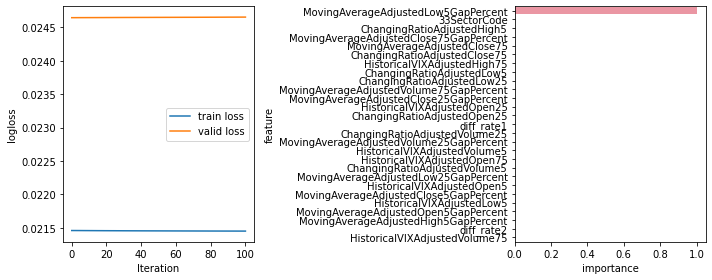

sharpe_ratio: -0.23873907750834863
score 0: -0.23873907750834863


[I 2022-04-22 10:29:34,763] A new study created in memory with name: no-name-68673aa1-7c9a-483e-b4d7-c7b920017883
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217852	Valid's rmse: 0.0222319
[200]	Train's rmse: 0.0217624	Valid's rmse: 0.0222

feature_fraction, val_score: 0.022205:  14%|#4        | 1/7 [00:15<01:31, 15.25s/it]

Early stopping, best iteration is:
[615]	Train's rmse: 0.0216997	Valid's rmse: 0.0222048
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training unti

feature_fraction, val_score: 0.022205:  29%|##8       | 2/7 [00:30<01:17, 15.45s/it]

Early stopping, best iteration is:
[640]	Train's rmse: 0.0217051	Valid's rmse: 0.0222064
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022205:  43%|####2     | 3/7 [00:46<01:01, 15.36s/it]

Early stopping, best iteration is:
[592]	Train's rmse: 0.021706	Valid's rmse: 0.0222067
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

feature_fraction, val_score: 0.022204:  57%|#####7    | 4/7 [00:59<00:43, 14.47s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0217147	Valid's rmse: 0.0222039
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022204:  71%|#######1  | 5/7 [01:16<00:31, 15.50s/it]

Early stopping, best iteration is:
[627]	Train's rmse: 0.0216896	Valid's rmse: 0.0222038
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022203:  86%|########5 | 6/7 [01:30<00:15, 15.06s/it]

Early stopping, best iteration is:
[534]	Train's rmse: 0.0217066	Valid's rmse: 0.0222031
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022201: 100%|##########| 7/7 [01:46<00:00, 15.23s/it]


Early stopping, best iteration is:
[525]	Train's rmse: 0.0217033	Valid's rmse: 0.0222013


num_leaves, val_score: 0.022201:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215859	Valid's rmse: 0.0222297
[200]	Train's rmse: 0.0213987	Valid's rmse: 0.0222

num_leaves, val_score: 0.022201:   5%|5         | 1/20 [00:18<05:50, 18.46s/it]

Early stopping, best iteration is:
[104]	Train's rmse: 0.0215776	Valid's rmse: 0.0222273
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  10%|#         | 2/20 [00:38<05:50, 19.45s/it]

Early stopping, best iteration is:
[206]	Train's rmse: 0.0215636	Valid's rmse: 0.0222134
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  15%|#5        | 3/20 [01:00<05:51, 20.67s/it]

Early stopping, best iteration is:
[195]	Train's rmse: 0.0215119	Valid's rmse: 0.0222234
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  20%|##        | 4/20 [01:25<05:56, 22.30s/it]

[300]	Train's rmse: 0.0212824	Valid's rmse: 0.0222403
Early stopping, best iteration is:
[200]	Train's rmse: 0.0214319	Valid's rmse: 0.0222255
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validati

num_leaves, val_score: 0.022201:  25%|##5       | 5/20 [01:47<05:30, 22.02s/it]

Early stopping, best iteration is:
[205]	Train's rmse: 0.0215271	Valid's rmse: 0.0222166
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  30%|###       | 6/20 [02:09<05:09, 22.10s/it]

Early stopping, best iteration is:
[147]	Train's rmse: 0.0215069	Valid's rmse: 0.022228
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201:  35%|###5      | 7/20 [02:27<04:30, 20.79s/it]

Early stopping, best iteration is:
[105]	Train's rmse: 0.0215835	Valid's rmse: 0.0222261
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  40%|####      | 8/20 [02:38<03:32, 17.69s/it]

Early stopping, best iteration is:
[225]	Train's rmse: 0.0217206	Valid's rmse: 0.0222097
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  45%|####5     | 9/20 [02:58<03:22, 18.45s/it]

Early stopping, best iteration is:
[275]	Train's rmse: 0.0215603	Valid's rmse: 0.0222136
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  50%|#####     | 10/20 [03:13<02:53, 17.39s/it]

[300]	Train's rmse: 0.0216169	Valid's rmse: 0.0222158
Early stopping, best iteration is:
[203]	Train's rmse: 0.0216655	Valid's rmse: 0.0222113
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validati

num_leaves, val_score: 0.022201:  55%|#####5    | 11/20 [03:25<02:22, 15.82s/it]

[700]	Train's rmse: 0.021755	Valid's rmse: 0.0222082
Early stopping, best iteration is:
[605]	Train's rmse: 0.0217603	Valid's rmse: 0.0222065
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validatio

num_leaves, val_score: 0.022201:  60%|######    | 12/20 [03:40<02:03, 15.45s/it]

Early stopping, best iteration is:
[528]	Train's rmse: 0.0217118	Valid's rmse: 0.0222018
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  65%|######5   | 13/20 [03:52<01:41, 14.53s/it]

Early stopping, best iteration is:
[615]	Train's rmse: 0.0217753	Valid's rmse: 0.022209
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201:  70%|#######   | 14/20 [04:09<01:30, 15.11s/it]

Early stopping, best iteration is:
[246]	Train's rmse: 0.0216275	Valid's rmse: 0.0222069
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  75%|#######5  | 15/20 [04:20<01:09, 13.98s/it]

Early stopping, best iteration is:
[760]	Train's rmse: 0.0217903	Valid's rmse: 0.0222085
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  80%|########  | 16/20 [04:40<01:03, 15.87s/it]

Early stopping, best iteration is:
[155]	Train's rmse: 0.0215329	Valid's rmse: 0.0222278
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  85%|########5 | 17/20 [04:59<00:50, 16.74s/it]

Early stopping, best iteration is:
[208]	Train's rmse: 0.0215859	Valid's rmse: 0.022216
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201:  90%|######### | 18/20 [05:13<00:31, 15.90s/it]

Early stopping, best iteration is:
[210]	Train's rmse: 0.0216706	Valid's rmse: 0.0222097
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  95%|#########5| 19/20 [05:34<00:17, 17.39s/it]

Early stopping, best iteration is:
[207]	Train's rmse: 0.021543	Valid's rmse: 0.0222145
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201: 100%|##########| 20/20 [05:54<00:00, 17.73s/it]


Early stopping, best iteration is:
[155]	Train's rmse: 0.0215565	Valid's rmse: 0.0222216


bagging, val_score: 0.022201:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217821	Valid's rmse: 0.0222301
[200]	Train's rmse: 0.0217571	Valid's rmse: 0.0222

bagging, val_score: 0.022201:  10%|#         | 1/10 [00:15<02:22, 15.88s/it]

Early stopping, best iteration is:
[440]	Train's rmse: 0.0217134	Valid's rmse: 0.022212
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

bagging, val_score: 0.022201:  20%|##        | 2/10 [00:29<01:54, 14.30s/it]

Early stopping, best iteration is:
[358]	Train's rmse: 0.021727	Valid's rmse: 0.0222114
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

bagging, val_score: 0.022201:  30%|###       | 3/10 [00:48<01:57, 16.85s/it]

Early stopping, best iteration is:
[557]	Train's rmse: 0.0216952	Valid's rmse: 0.0222044
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022201:  40%|####      | 4/10 [01:04<01:38, 16.42s/it]

Early stopping, best iteration is:
[476]	Train's rmse: 0.0217096	Valid's rmse: 0.0222055
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022201:  50%|#####     | 5/10 [01:21<01:22, 16.49s/it]

Early stopping, best iteration is:
[450]	Train's rmse: 0.0217126	Valid's rmse: 0.0222106
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022201:  60%|######    | 6/10 [01:35<01:02, 15.74s/it]

Early stopping, best iteration is:
[385]	Train's rmse: 0.0217219	Valid's rmse: 0.0222089
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022201:  70%|#######   | 7/10 [01:55<00:51, 17.07s/it]

Early stopping, best iteration is:
[620]	Train's rmse: 0.0216895	Valid's rmse: 0.0222096
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022201:  80%|########  | 8/10 [02:07<00:30, 15.37s/it]

Early stopping, best iteration is:
[387]	Train's rmse: 0.0217247	Valid's rmse: 0.0222076
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022201:  90%|######### | 9/10 [02:24<00:15, 15.95s/it]

Early stopping, best iteration is:
[494]	Train's rmse: 0.021708	Valid's rmse: 0.0222096
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

bagging, val_score: 0.022201: 100%|##########| 10/10 [02:39<00:00, 15.92s/it]


Early stopping, best iteration is:
[362]	Train's rmse: 0.0217259	Valid's rmse: 0.0222032


feature_fraction_stage2, val_score: 0.022201:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021782	Valid's rmse: 0.0222299
[200]	Train's rmse: 0.0217579	Valid's rmse: 0.02221

feature_fraction_stage2, val_score: 0.022201:  33%|###3      | 1/3 [00:16<00:32, 16.32s/it]

Early stopping, best iteration is:
[535]	Train's rmse: 0.0217013	Valid's rmse: 0.0222024
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction_stage2, val_score: 0.022201:  67%|######6   | 2/3 [00:33<00:16, 16.77s/it]

Early stopping, best iteration is:
[627]	Train's rmse: 0.0216891	Valid's rmse: 0.0222039
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction_stage2, val_score: 0.022201: 100%|##########| 3/3 [00:49<00:00, 16.47s/it]


Early stopping, best iteration is:
[525]	Train's rmse: 0.0217033	Valid's rmse: 0.0222013


regularization_factors, val_score: 0.022201:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217786	Valid's rmse: 0.0222285
[200]	Train's rmse: 0.0217509	Valid's rmse: 0.0222

regularization_factors, val_score: 0.022201:   5%|5         | 1/20 [00:12<03:48, 12.05s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0216957	Valid's rmse: 0.0222075
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  10%|#         | 2/20 [00:28<04:26, 14.79s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0217467	Valid's rmse: 0.0222206
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  15%|#5        | 3/20 [00:41<03:51, 13.63s/it]

Early stopping, best iteration is:
[459]	Train's rmse: 0.0216961	Valid's rmse: 0.0222077
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  20%|##        | 4/20 [00:52<03:27, 12.94s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0216963	Valid's rmse: 0.022207
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022201:  25%|##5       | 5/20 [01:05<03:12, 12.85s/it]

Early stopping, best iteration is:
[452]	Train's rmse: 0.0216971	Valid's rmse: 0.0222064
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  30%|###       | 6/20 [01:17<02:55, 12.54s/it]

Early stopping, best iteration is:
[459]	Train's rmse: 0.0216961	Valid's rmse: 0.0222065
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  35%|###5      | 7/20 [01:30<02:43, 12.61s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0216963	Valid's rmse: 0.0222059
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  40%|####      | 8/20 [01:42<02:29, 12.45s/it]

Early stopping, best iteration is:
[459]	Train's rmse: 0.0216962	Valid's rmse: 0.0222045
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  45%|####5     | 9/20 [01:54<02:15, 12.34s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0216963	Valid's rmse: 0.0222062
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  50%|#####     | 10/20 [02:07<02:04, 12.45s/it]

Early stopping, best iteration is:
[453]	Train's rmse: 0.0216973	Valid's rmse: 0.022205
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022201:  55%|#####5    | 11/20 [02:20<01:53, 12.61s/it]

Early stopping, best iteration is:
[345]	Train's rmse: 0.0217595	Valid's rmse: 0.0222217
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  60%|######    | 12/20 [02:31<01:38, 12.37s/it]

Early stopping, best iteration is:
[459]	Train's rmse: 0.0216959	Valid's rmse: 0.0222061
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  65%|######5   | 13/20 [02:45<01:28, 12.58s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0216959	Valid's rmse: 0.0222051
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022201:  70%|#######   | 14/20 [02:56<01:14, 12.39s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0216963	Valid's rmse: 0.0222059
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022200:  75%|#######5  | 15/20 [03:12<01:07, 13.40s/it]

Early stopping, best iteration is:
[527]	Train's rmse: 0.0216972	Valid's rmse: 0.0222001
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022195:  80%|########  | 16/20 [03:28<00:56, 14.01s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.021684	Valid's rmse: 0.0221953
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022195:  85%|########5 | 17/20 [03:43<00:43, 14.52s/it]

Early stopping, best iteration is:
[527]	Train's rmse: 0.0216973	Valid's rmse: 0.0222005
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022195:  90%|######### | 18/20 [03:58<00:29, 14.63s/it]

Early stopping, best iteration is:
[527]	Train's rmse: 0.0216982	Valid's rmse: 0.0222025
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022195:  95%|#########5| 19/20 [04:11<00:14, 14.13s/it]

Early stopping, best iteration is:
[450]	Train's rmse: 0.0217077	Valid's rmse: 0.0221998
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022195: 100%|##########| 20/20 [04:24<00:00, 13.22s/it]


Early stopping, best iteration is:
[460]	Train's rmse: 0.0216994	Valid's rmse: 0.0222051


min_data_in_leaf, val_score: 0.022195:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021781	Valid's rmse: 0.0222287
[200]	Train's rmse: 0.0217561	Valid's rmse: 0.02221

min_data_in_leaf, val_score: 0.022195:  20%|##        | 1/5 [00:15<01:02, 15.61s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.021684	Valid's rmse: 0.0221953
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train'

min_data_in_leaf, val_score: 0.022195:  40%|####      | 2/5 [00:32<00:48, 16.07s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.021684	Valid's rmse: 0.0221953
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 

min_data_in_leaf, val_score: 0.022195:  60%|######    | 3/5 [00:47<00:31, 15.82s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.021684	Valid's rmse: 0.0221953
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

min_data_in_leaf, val_score: 0.022195:  80%|########  | 4/5 [01:03<00:16, 16.08s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.021684	Valid's rmse: 0.0221953
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

min_data_in_leaf, val_score: 0.022195: 100%|##########| 5/5 [01:19<00:00, 15.91s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.021684	Valid's rmse: 0.0221953


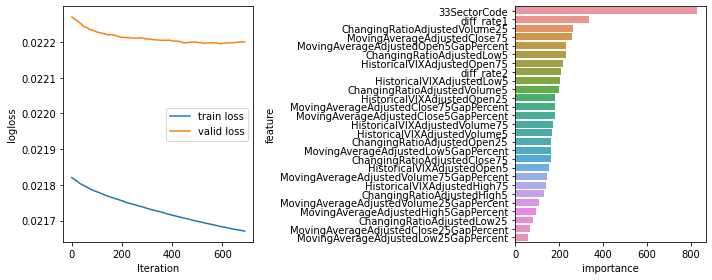

sharpe_ratio: 0.5320470026104983
score 1: 0.5320470026104983


[I 2022-04-22 10:46:29,801] A new study created in memory with name: no-name-5300ad9a-f5c6-49ba-969f-c8a342e30d2d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021517	Valid's rmse: 0.0250913
[200]	Train's rmse: 0.0214905	Valid's rmse: 0.02507

feature_fraction, val_score: 0.025021:  14%|#4        | 1/7 [00:24<02:28, 24.82s/it]

Early stopping, best iteration is:
[1030]	Train's rmse: 0.0213739	Valid's rmse: 0.0250205
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025021:  29%|##8       | 2/7 [00:47<01:56, 23.31s/it]

Early stopping, best iteration is:
[1030]	Train's rmse: 0.021387	Valid's rmse: 0.0250378
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.025018:  43%|####2     | 3/7 [01:20<01:51, 27.94s/it]

[2000]	Train's rmse: 0.0213158	Valid's rmse: 0.0250176
Did not meet early stopping. Best iteration is:
[2000]	Train's rmse: 0.0213158	Valid's rmse: 0.0250176
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training

feature_fraction, val_score: 0.025018:  57%|#####7    | 4/7 [01:42<01:16, 25.43s/it]

Early stopping, best iteration is:
[1029]	Train's rmse: 0.0213837	Valid's rmse: 0.0250321
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025018:  71%|#######1  | 5/7 [02:06<00:49, 24.98s/it]

Early stopping, best iteration is:
[1052]	Train's rmse: 0.0213719	Valid's rmse: 0.0250194
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025018:  86%|########5 | 6/7 [02:32<00:25, 25.35s/it]

Early stopping, best iteration is:
[1147]	Train's rmse: 0.0213639	Valid's rmse: 0.0250215
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025018: 100%|##########| 7/7 [02:55<00:00, 25.08s/it]


Early stopping, best iteration is:
[1027]	Train's rmse: 0.0213792	Valid's rmse: 0.0250297


num_leaves, val_score: 0.025018:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214481	Valid's rmse: 0.0250826
[200]	Train's rmse: 0.0213639	Valid's rmse: 0.0250

num_leaves, val_score: 0.024978:   5%|5         | 1/20 [00:46<14:44, 46.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214468	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213611	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  10%|#         | 2/20 [01:39<15:00, 50.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215015	Valid's rmse: 0.0251005
[200]	Train's rmse: 0.0214612	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  15%|#5        | 3/20 [02:10<11:47, 41.63s/it]

[1300]	Train's rmse: 0.0212327	Valid's rmse: 0.025006
Early stopping, best iteration is:
[1203]	Train's rmse: 0.0212484	Valid's rmse: 0.0250036
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validat

num_leaves, val_score: 0.024975:  20%|##        | 4/20 [02:51<11:02, 41.41s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214915	Valid's rmse: 0.0250954
[200]	Train's rmse: 0.0214435	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  25%|##5       | 5/20 [03:27<09:52, 39.52s/it]

Early stopping, best iteration is:
[1144]	Train's rmse: 0.0211867	Valid's rmse: 0.0249984
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

num_leaves, val_score: 0.024975:  30%|###       | 6/20 [04:39<11:48, 50.59s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214958	Valid's rmse: 0.0250975
[200]	Train's rmse: 0.0214509	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  35%|###5      | 7/20 [05:14<09:51, 45.46s/it]

Early stopping, best iteration is:
[1195]	Train's rmse: 0.0212081	Valid's rmse: 0.0249993
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

num_leaves, val_score: 0.024975:  40%|####      | 8/20 [06:23<10:32, 52.74s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0213762	Valid's rmse: 0.0250771
[200]	Train's rmse: 0.0212281	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  45%|####5     | 9/20 [07:12<09:27, 51.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214322	Valid's rmse: 0.0250819
[200]	Train's rmse: 0.021334	Valid's rmse: 0.02504

num_leaves, val_score: 0.024975:  50%|#####     | 10/20 [08:02<08:33, 51.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214178	Valid's rmse: 0.0250805
[200]	Train's rmse: 0.0213062	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  55%|#####5    | 11/20 [08:44<07:14, 48.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214397	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213477	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  60%|######    | 12/20 [09:32<06:25, 48.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214525	Valid's rmse: 0.0250842
[200]	Train's rmse: 0.0213721	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  65%|######5   | 13/20 [10:17<05:30, 47.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214077	Valid's rmse: 0.0250779
[200]	Train's rmse: 0.0212876	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  70%|#######   | 14/20 [11:17<05:06, 51.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214563	Valid's rmse: 0.0250854
[200]	Train's rmse: 0.0213788	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  75%|#######5  | 15/20 [12:06<04:12, 50.48s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214617	Valid's rmse: 0.0250854
[200]	Train's rmse: 0.0213888	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  80%|########  | 16/20 [12:52<03:16, 49.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214014	Valid's rmse: 0.0250782
[200]	Train's rmse: 0.0212764	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  85%|########5 | 17/20 [13:55<02:39, 53.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215512	Valid's rmse: 0.0251341
[200]	Train's rmse: 0.0215423	Valid's rmse: 0.0251

num_leaves, val_score: 0.024975:  90%|######### | 18/20 [14:01<01:18, 39.02s/it]

Early stopping, best iteration is:
[451]	Train's rmse: 0.0215298	Valid's rmse: 0.0251183
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.024975:  95%|#########5| 19/20 [14:38<00:38, 38.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214638	Valid's rmse: 0.0250874
[200]	Train's rmse: 0.0213927	Valid's rmse: 0.0250

bagging, val_score: 0.024975:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214387	Valid's rmse: 0.0250873
[200]	Train's rmse: 0.0213452	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  10%|#         | 1/10 [00:54<08:08, 54.28s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214396	Valid's rmse: 0.0250828
[200]	Train's rmse: 0.0213484	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  20%|##        | 2/10 [01:42<06:47, 50.94s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214413	Valid's rmse: 0.0250812
[200]	Train's rmse: 0.0213516	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  30%|###       | 3/10 [02:31<05:50, 50.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214406	Valid's rmse: 0.0250821
[200]	Train's rmse: 0.0213488	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  40%|####      | 4/10 [03:12<04:37, 46.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214431	Valid's rmse: 0.0250854
[200]	Train's rmse: 0.0213541	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  50%|#####     | 5/10 [03:59<03:52, 46.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214356	Valid's rmse: 0.0250852
[200]	Train's rmse: 0.0213419	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  60%|######    | 6/10 [04:41<03:00, 45.05s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214415	Valid's rmse: 0.0250831
[200]	Train's rmse: 0.0213514	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  70%|#######   | 7/10 [05:34<02:22, 47.66s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214501	Valid's rmse: 0.0250853
[200]	Train's rmse: 0.0213673	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  80%|########  | 8/10 [06:04<01:24, 42.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214394	Valid's rmse: 0.0250841
[200]	Train's rmse: 0.0213475	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  90%|######### | 9/10 [06:51<00:43, 43.61s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214394	Valid's rmse: 0.025084
[200]	Train's rmse: 0.0213475	Valid's rmse: 0.02505

feature_fraction_stage2, val_score: 0.024975:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214468	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213611	Valid's rmse: 0.0250

feature_fraction_stage2, val_score: 0.024975:  33%|###3      | 1/3 [00:51<01:42, 51.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214427	Valid's rmse: 0.0250774
[200]	Train's rmse: 0.0213548	Valid's rmse: 0.0250

feature_fraction_stage2, val_score: 0.024975:  67%|######6   | 2/3 [01:39<00:49, 49.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214399	Valid's rmse: 0.0250755
[200]	Train's rmse: 0.0213503	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214019	Valid's rmse: 0.0250925
[200]	Train's rmse: 0.0212786	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:   5%|5         | 1/20 [00:24<07:50, 24.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214027	Valid's rmse: 0.0250896
[200]	Train's rmse: 0.0212797	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  10%|#         | 2/20 [00:49<07:21, 24.50s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214138	Valid's rmse: 0.0250869
[200]	Train's rmse: 0.0212991	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  15%|#5        | 3/20 [01:16<07:22, 26.03s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021404	Valid's rmse: 0.0250898
[200]	Train's rmse: 0.0212814	Valid's rmse: 0.02506

regularization_factors, val_score: 0.024975:  20%|##        | 4/20 [01:42<06:55, 25.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214018	Valid's rmse: 0.0250893
[200]	Train's rmse: 0.0212783	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  25%|##5       | 5/20 [02:11<06:42, 26.85s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214019	Valid's rmse: 0.0250925
[200]	Train's rmse: 0.0212786	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  30%|###       | 6/20 [02:34<06:01, 25.80s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214015	Valid's rm

regularization_factors, val_score: 0.024975:  35%|###5      | 7/20 [03:01<05:38, 26.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214019	Valid's rmse: 0.0250925
[200]	Train's rmse: 0.0212786	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  40%|####      | 8/20 [03:26<05:09, 25.77s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214387	Valid's rmse: 0.0250812
[200]	Train's rmse: 0.0213458	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  45%|####5     | 9/20 [04:11<05:49, 31.78s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214014	Valid's rmse: 0.0250912
[200]	Train's rmse: 0.0212779	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  50%|#####     | 10/20 [04:39<05:05, 30.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	Train's rmse: 0.0215064

regularization_factors, val_score: 0.024975:  55%|#####5    | 11/20 [05:41<06:00, 40.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214034	Valid's rmse: 0.0250906
[200]	Train's rmse: 0.0212812	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  60%|######    | 12/20 [06:16<05:10, 38.77s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214149	Valid's rmse: 0.0250873
[200]	Train's rmse: 0.0213026	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  65%|######5   | 13/20 [06:43<04:04, 34.99s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation s

regularization_factors, val_score: 0.024975:  70%|#######   | 14/20 [07:49<04:26, 44.34s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214053	Valid's rm

regularization_factors, val_score: 0.024975:  75%|#######5  | 15/20 [08:16<03:15, 39.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214019	Valid's rmse: 0.0250925
[200]	Train's rmse: 0.0212786	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  80%|########  | 16/20 [08:41<02:19, 34.88s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021431	Valid's rmse: 0.0250846
[200]	Train's rmse: 0.0213322	Valid's rmse: 0.02505

regularization_factors, val_score: 0.024975:  85%|########5 | 17/20 [09:23<01:51, 37.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214312	Valid's rmse: 0.0250844
[200]	Train's rmse: 0.0213325	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  90%|######### | 18/20 [09:54<01:10, 35.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214528	Valid's rmse: 0.0250835
[200]	Train's rmse: 0.0213718	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  95%|#########5| 19/20 [10:47<00:40, 40.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No furth

min_data_in_leaf, val_score: 0.024975:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214468	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213611	Valid's rmse: 0.

min_data_in_leaf, val_score: 0.024975:  20%|##        | 1/5 [00:53<03:35, 53.82s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214468	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213611	Valid's rmse: 0.0250

min_data_in_leaf, val_score: 0.024975:  40%|####      | 2/5 [01:46<02:39, 53.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214468	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213611	Valid's rmse: 0.0250513


min_data_in_leaf, val_score: 0.024975:  60%|######    | 3/5 [02:40<01:46, 53.49s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214468	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213611	Valid's rmse: 0.0250

min_data_in_leaf, val_score: 0.024975:  80%|########  | 4/5 [03:32<00:52, 52.92s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214468	Valid's rmse: 0.0250825
[200]	Train's rmse: 0.0213611	Valid's rmse: 0.0250

min_data_in_leaf, val_score: 0.024975: 100%|##########| 5/5 [04:26<00:00, 53.23s/it]


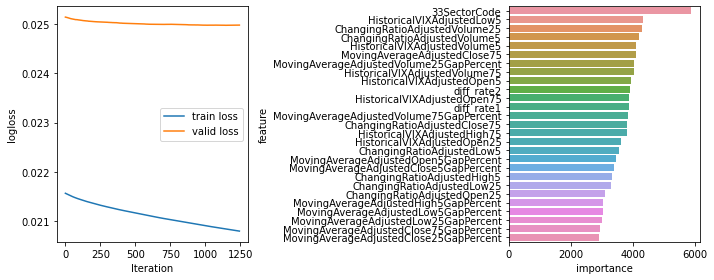

sharpe_ratio: 0.4468949391315575
score 2: 0.4468949391315575
CV_SCORES: [-0.23873907750834863, 0.5320470026104983, 0.4468949391315575]
CV_SCORE: 0.24673428807790235


In [7]:
# 2020-12-23よりも前のデータは証券コードが2000個すべて揃っていないため、これ以降のデータのみを使う。
# (学習用データの開始日、学習用データの終了日＝検証用データの開始日、検証用データの終了日)
fold_params = [
    ('2020-12-23', '2021-11-01', '2021-12-01'),
    ('2021-01-23', '2021-12-01', '2022-01-01'),
    ('2021-02-23', '2022-01-01', '2022-02-01'),
]
models = trainer(feature_df, feat_cols, label_col, fold_params, use_cache=False)
models

# Evaluation

In [8]:
def predictor(feature_df, feat_cols, models, is_train=True):
    X = feature_df[feat_cols]
    
    # 推論
    preds = list(map(lambda model: model.predict(X, num_iteration=model.best_iteration), models))
    print(f"preds: {preds}")
    
    # スコアは学習時のみ計算
    if is_train:
        scores = list(map(lambda pred: evaluator(feature_df, pred), preds))
        print("SCORES:", scores)

    # 推論結果をバギング
    pred = np.array(preds).mean(axis=0)

    # スコアは学習時のみ計算
    if is_train:
        score = evaluator(feature_df, pred)
        print("SCORE:", score)
    
    return pred

def eval_predictor(df, feat_cols, models, target_date=['2022-2-01', '2022-2-27']):
    # 日次で推論・登録
    print(f"target_date: {target_date}")
    target_df = df.copy()
    target_df = target_df[(target_date[0] <= target_df['Date']) & (target_df['Date'] < target_date[1])]

    # 推論20
    target_df["pred"] = predictor(target_df, feat_cols, models, True)

    # 推論結果からRANKを導出し、提出データに反映
    result_df = add_rank(target_df)
    return result_df

In [9]:
_df = eval_predictor(feature_df, feat_cols, models)
#pred_df = _df[0]
#pred_df = pred_df[["SecuritiesCode", "pred", "Date", "Rank"]]
#target_df = _df[1]
#target_df = target_df[["SecuritiesCode", "Target"]]
#result_df = pred_df.merge(target_df, on='SecuritiesCode', how="left")
#write_df(result_df, "result_df")
_df

target_date: ['2022-2-01', '2022-2-27']
preds: [array([0.00073817, 0.00073817, 0.00073817, ..., 0.00074767, 0.00074767,
       0.00073817]), array([-2.68019620e-04,  1.61962650e-04, -3.81987668e-05, ...,
        1.47493391e-03,  9.74953254e-04, -1.22408543e-03]), array([-2.75216639e-04,  2.90376109e-05, -6.48490413e-04, ...,
        2.57841894e-03,  2.42209494e-03, -2.66956545e-03])]
sharpe_ratio: -0.3183487920363959
sharpe_ratio: -0.01671803948413025
sharpe_ratio: 0.022719276203177714
SCORES: [-0.3183487920363959, -0.01671803948413025, 0.022719276203177714]
sharpe_ratio: 0.03824054468849757
SCORE: 0.03824054468849757


,RowId,Date,SecuritiesCode,ChangingRatioAdjustedClose25,ChangingRatioAdjustedClose5,ChangingRatioAdjustedClose75,ChangingRatioAdjustedHigh25,ChangingRatioAdjustedHigh5,ChangingRatioAdjustedHigh75,ChangingRatioAdjustedLow25,...,MovingAverageAdjustedVolume75,MovingAverageAdjustedVolume75GapPercent,diff_rate1,diff_rate2,NewMarketSegment,33SectorCode,17SectorCode,Target,pred,Rank
1239,20220201_1301,2022-02-01,1301,3.770492,1.118211,5.149502,3.425775,1.277955,3.934426,3.119869,...,12514.666667,86.298743,0.003160,0.009479,Prime Market,50,1,0.003096,0.000065,814
1240,20220202_1301,2022-02-02,1301,6.776860,3.194888,7.774441,6.065574,2.373418,6.765677,4.462810,...,12720.000000,184.748428,0.018576,0.023220,Prime Market,50,1,0.003086,0.000310,1452
1241,20220203_1301,2022-02-03,1301,6.754530,4.180064,8.252589,6.732348,3.174603,7.973422,5.940594,...,12801.333333,121.862306,0.000000,0.012346,Prime Market,50,1,-0.024615,0.000017,1284
1242,20220204_1301,2022-02-04,1301,5.008078,5.008078,6.557377,5.654281,4.306220,7.213115,5.436573,...,13270.666667,327.790616,0.000000,0.021538,Prime Market,50,1,0.023659,0.000237,1494
1243,20220207_1301,2022-02-07,1301,2.258065,0.634921,4.448105,4.193548,2.539683,5.728314,3.425775,...,13313.333333,102.153230,-0.012618,0.018927,Prime Market,50,1,-0.004622,0.000588,1043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436633,20220218_9997,2022-02-18,9997,0.546448,-3.285151,-8.571429,-0.405954,-4.539559,-9.247842,-1.104972,...,265093.333333,66.429434,0.019022,0.027174,Prime Market,6100,14,-0.008253,0.002221,345
2436634,20220221_9997,2022-02-21,9997,1.820728,-2.937250,-8.897243,-0.545703,-3.058511,-9.553350,1.125176,...,263338.666667,44.201636,0.002751,0.013755,Prime Market,6100,14,-0.002774,0.000485,1270
2436635,20220222_9997,2022-02-22,9997,-1.637108,-2.699055,-6.967742,-2.032520,-3.728362,-9.056604,-0.974930,...,257701.333333,87.504398,0.002774,0.016644,Prime Market,6100,14,0.019471,0.001600,656
2436636,20220224_9997,2022-02-24,9997,-2.442334,-2.968961,-5.519054,-4.100529,-4.227213,-7.407407,-2.880658,...,255014.666667,76.701471,0.013908,0.023644,Prime Market,6100,14,0.001364,0.001382,915


# Submit

In [10]:
# 時系列APIのロード
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [11]:
# supplemental filesを履歴データの初期状態としてセットアップ
past_df = train_df.copy()

In [12]:
# 日次で推論・登録
for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(iter_test):
    current_date = prices["Date"].iloc[0]
    print(f"count {i}, {current_date}")

    if i == 0:
        # リークを防止するため、時系列APIから受け取ったデータより未来のデータを削除
        past_df = past_df[past_df["Date"] < current_date]

    # リソース確保のため古い履歴を削除
    threshold = (pd.Timestamp(current_date) - pd.offsets.BDay(80))
    past_df = past_df[past_df["Date"] >= threshold]
    
    # 時系列APIから受け取ったデータを履歴データに統合
    base_df = collector(prices, options, financials, trades, secondary_prices, stock_list)
    past_df = pd.concat([past_df, base_df]).reset_index(drop=True)

    # 特徴量エンジニアリング
    feature_df, feat_cols, label_col = preprocessor(past_df, False)

    # 予測対象レコードだけを抽出
    feature_df = feature_df[feature_df['Date'] == current_date]

    # 推論
    feature_df["pred"] = predictor(feature_df, feat_cols, models, False)

    # 推論結果からRANKを導出し、提出データに反映
    feature_df = add_rank(feature_df)
    write_df(feature_df, f"result_{i}")
    feature_map = feature_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(feature_map)

    # 結果を登録
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
count 0, 2021-12-06
preds: [array([0.00073817, 0.00073817, 0.00073817, ..., 0.00074767, 0.00073817,
       0.00073817]), array([-0.00183815, -0.00078291,  0.0002153 , ...,  0.00095909,
        0.00013279,  0.00028044]), array([-0.00251258, -0.00290485, -0.00146348, ...,  0.00237238,
       -0.00044787, -0.00109379])]
count 1, 2021-12-07
preds: [array([0.00073817, 0.00074767, 0.00073817, ..., 0.00074767, 0.00073817,
       0.00073817]), array([ 6.45879504e-04, -8.29771546e-04,  4.13145893e-04, ...,
        6.35339836e-04, -6.53932985e-05,  5.86580550e-04]), array([ 0.00108188, -0.00208913, -0.00126981, ...,  0.00055182,
       -0.00074936, -0.00075155])]
